In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICE"] = "1"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten, TimeDistributed, Reshape
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

2024-06-22 09:48:04.592738: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:

# Directories
train_dir = "DatasetFour/TrainFour"
test_dir = "DatasetFour/TestFour"


In [4]:

# Hyperparameters
SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 4
EPOCHS = 5
LR = 0.00003



In [5]:
# Dictionary to store crime types count
crimes = {}
train_count = test_count = 0
crime_types = os.listdir(train_dir)  # assuming crime_types are the directory names

for clss in crime_types:
    num_train = len(os.listdir(os.path.join(train_dir, clss)))
    num_test = len(os.listdir(os.path.join(test_dir, clss)))
    train_count += num_train
    test_count += num_test
    crimes[clss] = num_train



In [6]:
# Image dimensions
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH)
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
seed = 69


In [7]:

# Data Preparation
train_set = image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.7,
    subset="training",
)

val_set = image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="validation",
)

test_set = image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    class_names=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=False
)

Found 997147 files belonging to 4 classes.
Using 299145 files for training.


2024-06-22 09:48:28.838433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-22 09:48:28.838627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-22 09:48:28.843678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 997147 files belonging to 4 classes.
Using 199429 files for validation.
Found 81755 files belonging to 4 classes.


In [8]:
# Simplified LSTM Model
def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        TimeDistributed(Flatten(), input_shape=input_shape),
        Reshape((IMG_HEIGHT, IMG_WIDTH * 3)),  # Reshape for LSTM compatibility
        LSTM(32, return_sequences=True),  # Further reduced LSTM units
        Dropout(0.2),  # Further reduced dropout rate
        LSTM(32),
        Dropout(0.2),
        Dense(32, activation='relu'),  # Further reduced dense layer units
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [9]:
num_classes = len(crime_types)
model = create_lstm_model(INPUT_SHAPE, num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 64, 192)          0         
 ibuted)                                                         
                                                                 
 reshape (Reshape)           (None, 64, 192)           0         
                                                                 
 lstm (LSTM)                 (None, 64, 32)            28800     
                                                                 
 dropout (Dropout)           (None, 64, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

2024-06-22 09:48:53.315019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-22 09:48:53.315973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-22 09:48:53.316659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [10]:
# Model Compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.AUC(), 'accuracy'])

In [11]:
# Model Training
history = model.fit(train_set, validation_data=val_set, epochs=EPOCHS)


Epoch 1/5


2024-06-22 09:48:53.495681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [299145]
	 [[{{node Placeholder/_4}}]]
2024-06-22 09:48:53.495874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [299145]
	 [[{{node Placeholder/_0}}]]
2024-06-22 09:48:53.625842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_di

74783/74787 [============================>.] - ETA: 0s - loss: 0.1742 - auc: 0.9896 - accuracy: 0.9614

2024-06-22 09:55:09.147670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [199429]
	 [[{{node Placeholder/_4}}]]
2024-06-22 09:55:09.147941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [199429]
	 [[{{node Placeholder/_0}}]]
2024-06-22 09:55:09.288969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_di

74787/74787 [==============================] - 488s 6ms/step - loss: 0.1742 - auc: 0.9896 - accuracy: 0.9615 - val_loss: 0.1244 - val_auc: 0.9948 - val_accuracy: 0.9669
Epoch 2/5
74787/74787 [==============================] - 490s 7ms/step - loss: 0.1209 - auc: 0.9948 - accuracy: 0.9702 - val_loss: 0.1035 - val_auc: 0.9960 - val_accuracy: 0.9729
Epoch 3/5
74787/74787 [==============================] - 496s 7ms/step - loss: 0.1051 - auc: 0.9960 - accuracy: 0.9733 - val_loss: 0.0916 - val_auc: 0.9967 - val_accuracy: 0.9761
Epoch 4/5
74787/74787 [==============================] - 490s 7ms/step - loss: 0.0945 - auc: 0.9966 - accuracy: 0.9756 - val_loss: 0.0821 - val_auc: 0.9973 - val_accuracy: 0.9775
Epoch 5/5
74787/74787 [==============================] - 493s 7ms/step - loss: 0.0867 - auc: 0.9971 - accuracy: 0.9773 - val_loss: 0.0748 - val_auc: 0.9977 - val_accuracy: 0.9784


In [12]:
# Model Evaluation
test_loss, test_auc, test_accuracy = model.evaluate(test_set, verbose=2)
print(f'Test AUC: {test_auc:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

2024-06-22 10:29:50.290818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [81755]
	 [[{{node Placeholder/_4}}]]
2024-06-22 10:29:50.291167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [81755]
	 [[{{node Placeholder/_4}}]]


20439/20439 - 47s - loss: 1.1536 - auc: 0.8973 - accuracy: 0.7927 - 47s/epoch - 2ms/step
Test AUC: 0.8973
Test Accuracy: 0.7927


In [13]:
# Save the Model
model.save('lstm_ucf_crime_model.h5')


Text(0.5, 1.0, 'Training and Validation AUC')

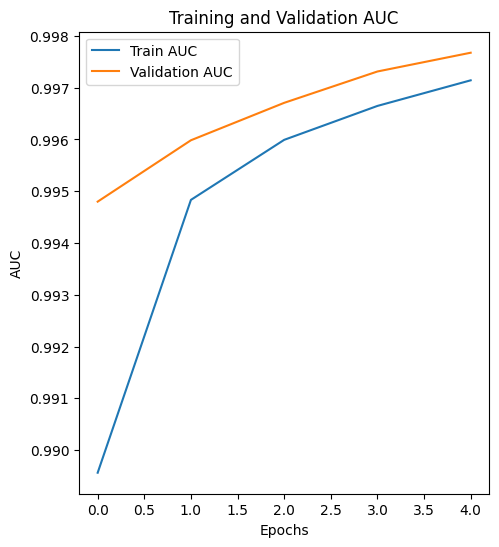

In [14]:

# Plot training history
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('Training and Validation AUC')



Text(0.5, 1.0, 'Training and Validation Accuracy')

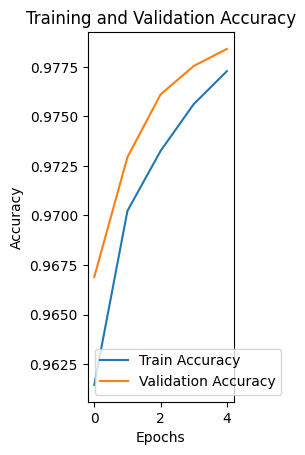

In [15]:
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')



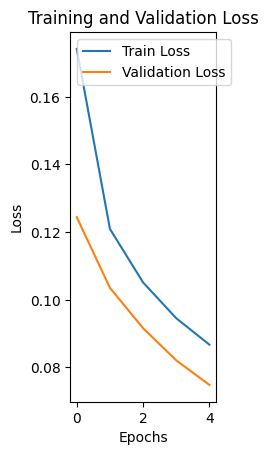

In [16]:
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [17]:

# Confusion Matrix
y_true = np.concatenate([y for x, y in test_set], axis=0)
y_pred = np.argmax(model.predict(test_set), axis=-1)
y_true = np.argmax(y_true, axis=-1)



2024-06-22 10:30:40.677372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-22 10:30:40.678316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-22 10:30:40.679035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20439/20439 [==============================] - 57s 3ms/step


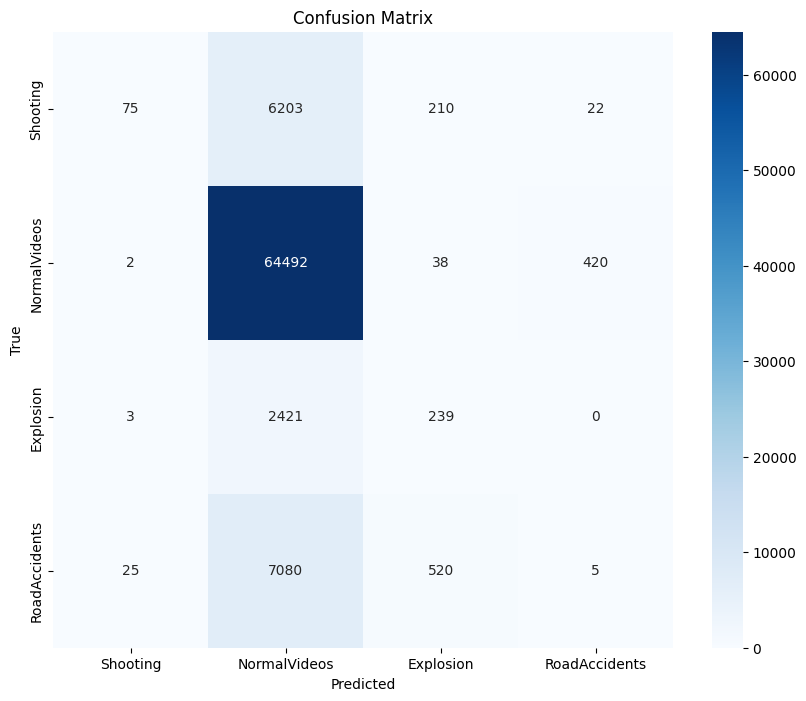

In [18]:

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=crime_types, yticklabels=crime_types)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=crime_types)
print(class_report)


               precision    recall  f1-score   support

     Shooting       0.71      0.01      0.02      6510
 NormalVideos       0.80      0.99      0.89     64952
    Explosion       0.24      0.09      0.13      2663
RoadAccidents       0.01      0.00      0.00      7630

     accuracy                           0.79     81755
    macro avg       0.44      0.27      0.26     81755
 weighted avg       0.70      0.79      0.71     81755

